**Source Detection for Point Sources**  
@Author: Ray  
@Time: 2022.09.19  
@Cite: [photutils.detection](https://photutils.readthedocs.io/en/stable/detection.html)  
@Note: `photutils.detection`模块是专门用于探测点源的；对于一般的源检测（点源/展源）应使用[photutils.segmentation](https://photutils.readthedocs.io/en/stable/segmentation.html)

photutils包含2种广泛使用的detect stars的算法：
* [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder)
    1. 算法描述：搜索图像中局域像素峰值大于指定阈值(`threshold`)且大小和形状与定义的2D高斯核(`fwhm`, `ratio`, `theta`, `sigma_radius`)相似的局部密度最大值。
    2. 优势：能使用椭圆的高斯核
* [IRAFStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.IRAFStarFinder.html#photutils.detection.IRAFStarFinder)
    1. 算法描述：搜索图像中局域像素峰值大于指定阈值(`threshold`)，并且PSF的FWHM和输入的fwhm类似的objects
    2. 优势：同时测量目标的中心位置

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import SqrtStretch, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize

---
## 加载实验图像

In [2]:
# 加载实验图像
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
hdu = load_star_image()  
hdu.data.shape

(1059, 1059)

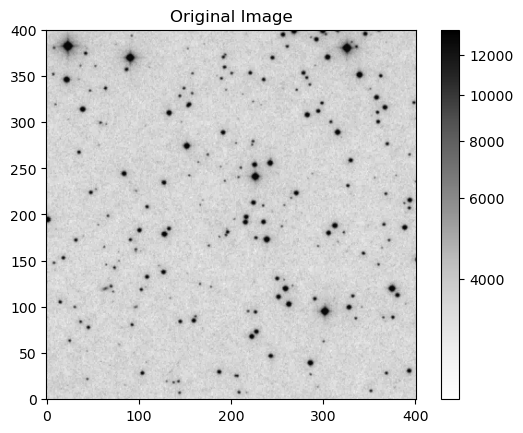

In [3]:
data = hdu.data[0:401, 0:401]  # 选择数据的一部分

norm = ImageNormalize(interval=MinMaxInterval(), stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys')
plt.title("Original Image")
plt.colorbar()

In [4]:
# 简单估计背景噪声
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std)) 

(3668.09661145823, 3649.0, 204.41388592022315)


---
## 使用`DAOStarFinder`找星
* 找出图像中FWHN约为3pixels，像素峰值在背景的5个sigma之外的目标源

In [5]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  # 算法实例化
sources = daofind(data - median)  # 执行找星，返回结果表格
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
sources.show_in_notebook()  # 需要安装模块ipywidgets
# print(sources)

---
## 画出探测到的源在图像中的位置

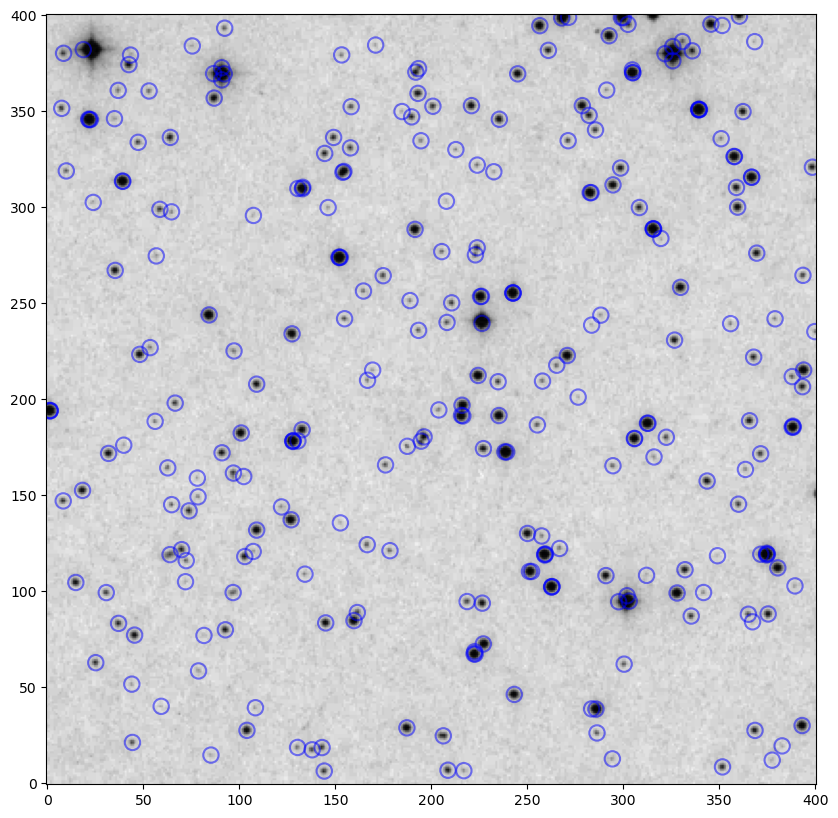

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)

plt.figure(figsize=(10, 10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5);

---
## Mask部分区域
* 可以使用mask参数，排除部分区域不参与找星

In [7]:
# 设置mask image
mask = np.zeros(data.shape, dtype=bool)  # 参与找星的区域设置为False
mask[50:151, 50:351] = True  # 不参与找星的区域设置为True
mask[250:351, 150:351] = True

from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data-median, mask=mask)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
# sources.show_in_browser()
print(sources)

 id xcentroid ycentroid sharpness  ... sky peak    flux       mag     
--- --------- --------- ---------- ... --- ---- --------- ------------
  1 144.24757 6.3797904 0.58156257 ...   0 6903 5.6976747   -1.8892441
  2 208.66907 6.8205805 0.48348966 ...   0 7896 6.7186388   -2.0682032
  3 216.92614 6.5775933 0.69359525 ...   0 2195 1.6662764  -0.55436758
  4 351.62519 8.5459013 0.48577834 ...   0 6977 5.8970385   -1.9265849
  5 377.51991 12.065501 0.52038488 ...   0 1260 1.1178252  -0.12093477
  6 294.27284 12.737191 0.68021892 ...   0 2059 1.4809613  -0.42635928
  7 85.217728 14.710347 0.62394134 ...   0 1458 1.2457081  -0.23854075
  8 137.94129 17.464718 0.54340548 ...   0 5451 4.6833069   -1.6763815
  9 130.32797 18.678087 0.62723987 ...   0 3432 2.8641222   -1.1424789
 10  143.1105 18.623553 0.52124876 ...   0 6722 5.7556336   -1.9002329
...       ...       ...        ... ... ...  ...       ...          ...
184 292.58712 389.31304  0.3548582 ...   0 9231   4.64095   -1.6665172
185  9

(<matplotlib.patches.Rectangle at 0x12361b340>,)

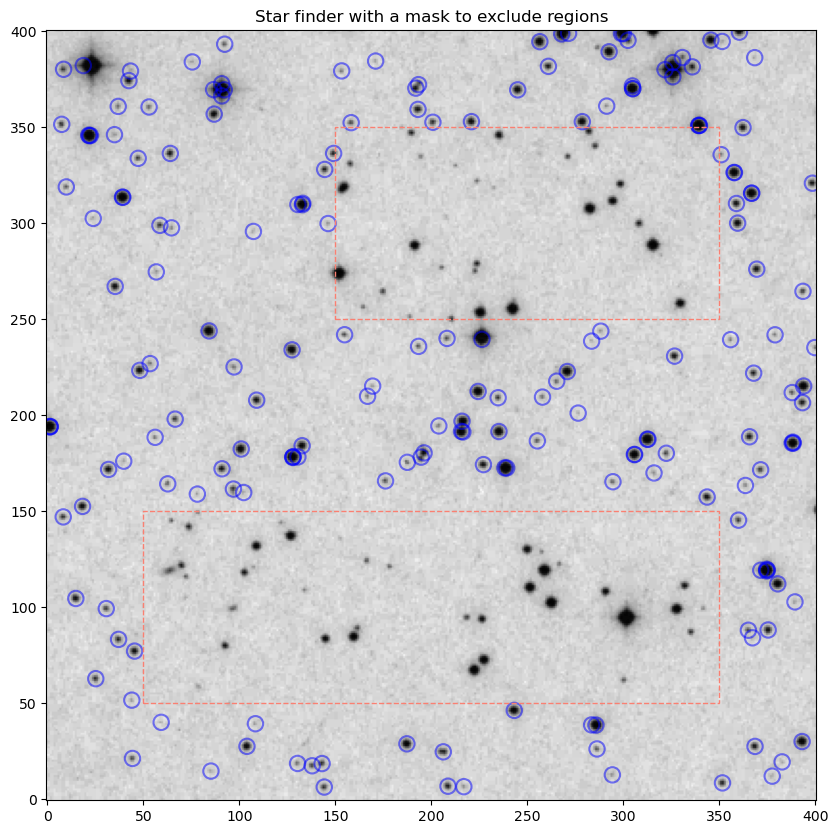

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, RectangularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)

plt.figure(figsize=(10, 10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
plt.title('Star finder with a mask to exclude regions')

apertures.plot(color='blue', lw=1.5, alpha=0.5)
rect1 = RectangularAperture((200, 100), 300, 100, theta=0.)
rect2 = RectangularAperture((250, 300), 200, 100, theta=0.)
rect1.plot(color='salmon', ls='dashed')
rect2.plot(color='salmon', ls='dashed')

---
## 使用`find_peaks`找local peaks  
跟找星有些区别：
* find_peaks目标是寻找图像中的局域像素峰值
* 返回的位置是最亮像素的位置，而不是面心的位置，`centroid_func`参数可计算面心位置

In [9]:
from photutils.detection import find_peaks

threshold = median + (5. * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'
print(tbl)

x_peak y_peak peak_value
------ ------ ----------
   144      6      10552
   209      7      11545
   217      7       5844
   352      8      10626
   352      9      10626
    16     11       4778
   377     12       4909
   294     13       5708
    23     14       4823
    85     15       5107
   ...    ...        ...
   269    398      13129
   196    399       4692
   268    399      13129
   299    399      13084
   150    400       4874
   158    400       4828
   299    400      13084
   315    400      13038
   316    400      13038
   360    400      12999
   361    400      12999
Length = 334 rows


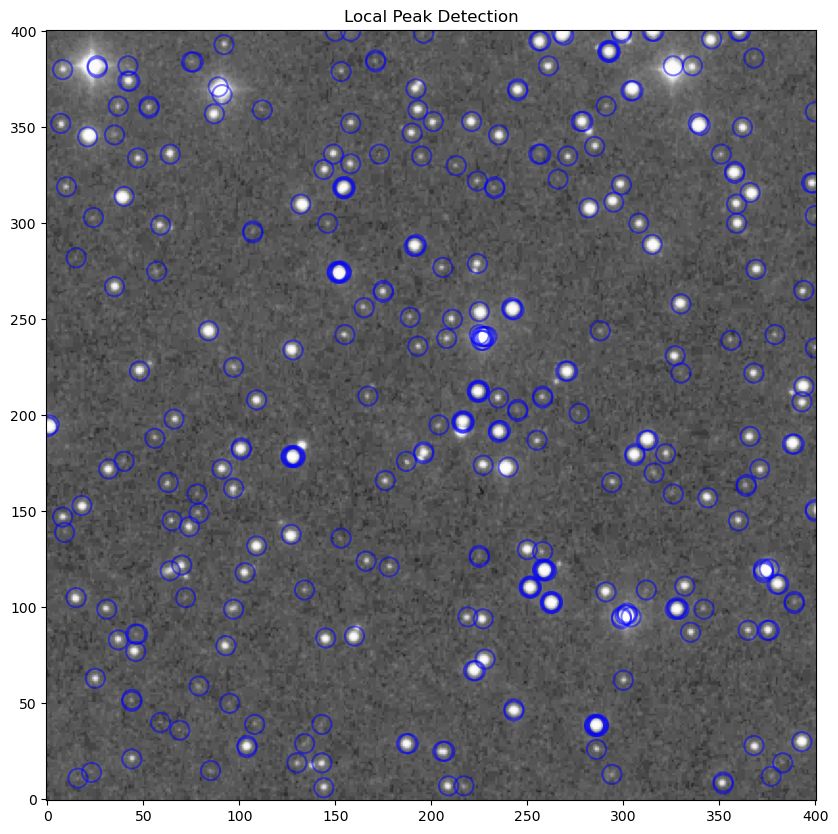

In [10]:
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.)

plt.figure(figsize=(10, 10))
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm)
plt.title("Local Peak Detection")
apertures.plot(color='blue', lw=1.5, alpha=0.5);